# Demo - Fourier Feature Networks

In [38]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [39]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm as tqdm
import os, imageio

from ml4ssh._src.models.mlp import MLP
from ml4ssh._src.models.activations import Swish
from ml4ssh._src.data.images import load_fox
from ml4ssh._src.features import get_image_coordinates
from ml4ssh._src.datamodules.images import ImageFox, ImageCameraman
from torch.nn import ReLU
import pytorch_lightning as pl
from ml4ssh._src.models.image import ImageModel
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.utilities.argparse import add_argparse_args
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

In [40]:
img = load_fox()

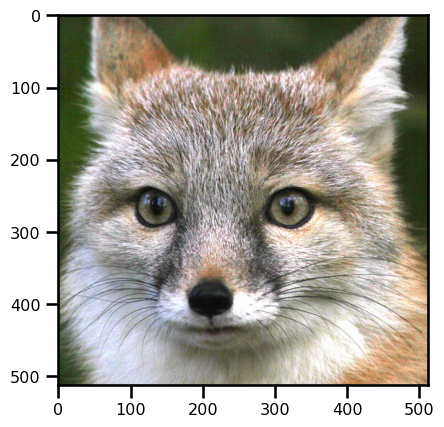

In [41]:
plt.figure()
plt.imshow(img)
plt.show()

### Data Module

In [67]:
# dm = ImageFox(batch_size=1024).setup()
dm = ImageFox(batch_size=4096, shuffle=False).setup()

In [68]:
len(dm.ds_train)

131072

## Multi-layer Perceptron (MLP)


### Swish Activation Layer

In [69]:
init = dm.ds_train[:32]
x_init, y_init = init
x_init.shape, y_init.shape

(torch.Size([32, 2]), torch.Size([32, 3]))

In [70]:
out = Swish()(x_init)

out.shape

torch.Size([32, 2])

In [71]:
# x_img = rearrange(out.numpy(), "(x y) c -> x y c", x=img.shape[0], y=img.shape[0])

In [72]:
# plt.imshow(x_img)
# plt.show()

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *swish* activation function.

$$
\sigma(\mathbf{x}) = \mathbf{x} \odot \text{Sigmoid}(\mathbf{x})
$$

In [73]:
dim_in = x_init.shape[1]
dim_hidden = 256
dim_out = y_init.shape[1]
num_layers = 4
activation = Swish() #nn.ReLU()#
final_activation = nn.Sigmoid()

mlp_net = MLP(
    dim_in=dim_in,
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    num_layers=num_layers,
    activation=activation,
    final_activation=final_activation
)

In [74]:
out = mlp_net(x_init)

In [75]:
# x_img = rearrange(out.detach().numpy(), "(x y) c -> x y c", x=img.shape[0], y=img.shape[0])

In [76]:
mlp_net

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (activation): Swish()
  (last_layer): Linear(in_features=256, out_features=3, bias=True)
)

## Experiment

In [77]:
import pytorch_lightning as pl
pl.seed_everything(123)

Global seed set to 123


123

#### Dataset



In [78]:
learning_rate = 1e-4
mlp_net = MLP(
    dim_in=dim_in,
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    num_layers=num_layers,
    activation=activation
)
dm = ImageFox(batch_size=4096, shuffle=True).setup()

In [79]:
learn = ImageModel(mlp_net, learning_rate=learning_rate)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [81]:
callbacks = [
    TQDMProgressBar(refresh_rate=50)
]

In [82]:
trainer = Trainer(
    min_epochs=1,
    max_epochs=100,
    accelerator="mps",
    enable_progress_bar=True,
    logger=None,
    callbacks=callbacks,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [83]:
trainer.fit(
    learn,
    datamodule=dm,
)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /Users/eman/code_projects/ml4ssh/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type    | Params
----------------------------------
0 | model | MLP     | 198 K 
1 | loss  | MSELoss | 0     
----------------------------------
198 K     Trainable params
0         Non-trainable params
198 K     Total params
0.796     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [84]:
trainer.test(learn, dataloaders=dm.test_dataloader())


/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.04827561974525452    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04827561974525452}]

In [85]:
# t0 = time.time()
predictions = trainer.predict(learn, dataloaders=dm, return_predictions=True)
predictions = torch.cat(predictions)
# t1 = time.time() - t0

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 32it [00:00, ?it/s]

In [86]:
img_pred = dm.coordinates_2_image(predictions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


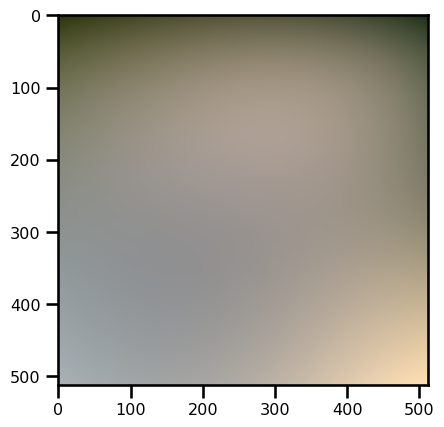

In [87]:
plt.figure()
plt.imshow(img_pred, cmap="gray")
plt.show()

### Encoders

In [25]:
from ml4ssh._src.models.encoders import (
    IdentityPositionalEncoding,
    NeRFPositionalEncoding,
    GaussianFourierFeatureTransform
)
from ml4ssh._src.models.ffn import FourierFeatureMLP

In [26]:
encoder = IdentityPositionalEncoding(in_dim=dim_in)
encoder = NeRFPositionalEncoding(in_dim=dim_in, n=50)
encoder = GaussianFourierFeatureTransform(in_dim=dim_in, mapping_size=256, sigma=1.0)

In [27]:
out = encoder(x_init)
x_init.shape, out.shape

(torch.Size([32, 2]), torch.Size([32, 512]))

In [28]:
dim_in = x_init.shape[1]
dim_hidden = 256
dim_out = y_init.shape[1]
num_layers = 4
activation = Swish()
final_activation = nn.Sigmoid()

ffn_net = FourierFeatureMLP(
    encoder=encoder,
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    num_layers=num_layers,
    activation=activation,
    final_activation=final_activation
)

In [29]:
out = ffn_net(x_init)
x_init.shape, out.shape

(torch.Size([32, 2]), torch.Size([32, 3]))

In [30]:
learning_rate = 1e-4
ffn_net = FourierFeatureMLP(
    encoder=encoder,
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    num_layers=num_layers,
    activation=activation,
    final_activation=final_activation
)
dm = ImageFox(batch_size=4096).setup()

In [31]:
learn = ImageModel(ffn_net, learning_rate=learning_rate)

In [32]:
trainer = Trainer(
    min_epochs=1,
    max_epochs=100,
    accelerator="mps",
    enable_progress_bar=True,
    logger=None,
    callbacks=callbacks,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(
    learn,
    datamodule=dm
)


  | Name  | Type              | Params
--------------------------------------------
0 | model | FourierFeatureMLP | 329 K 
1 | loss  | MSELoss           | 0     
--------------------------------------------
329 K     Trainable params
0         Non-trainable params
329 K     Total params
1.318     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [34]:
trainer.test(learn, dataloaders=dm.test_dataloader())

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.010853123851120472    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.010853123851120472}]

In [35]:
# t0 = time.time()
predictions = trainer.predict(learn, dataloaders=dm, return_predictions=True)
predictions = torch.cat(predictions)
# t1 = time.time() - t0

Predicting: 8it [00:00, ?it/s]

In [36]:
img_pred = dm.coordinates_2_image(predictions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


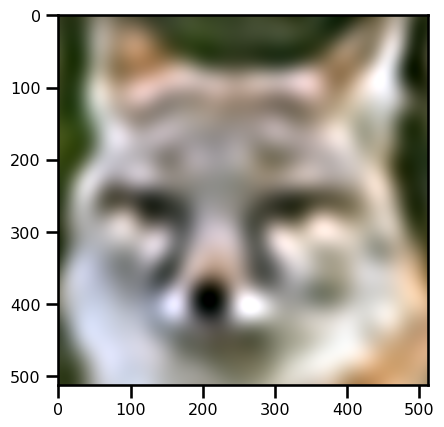

In [37]:
plt.figure()
plt.imshow(img_pred)
plt.show()